# Results analysis
Notebook to analyze the results of the various state-of-the-artn detectors.

## Libraries import

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import glob

## Execution params

In [2]:
results_dir = '/nas/public/exchange/JPEG-AI/test_results'
detectors_names = ['Grag2021_progan', 'Grag2021_latent']

## Load results - Grag 2021 ProGAN

In [3]:
results = pd.read_csv(os.path.join(results_dir, 'Grag2021_progan', 'results.csv'))
results

,Unnamed: 0,path,dataset,compressed,target_bpp,filename,content,size,logits
0,81384,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,456--n02879718_10059.png,various,"(256, 256)",-6.409775
1,81385,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,122--n01983481_8922.png,various,"(256, 256)",-21.786558
2,81386,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,730--n03967562_27019.png,various,"(256, 256)",-15.939739
3,81387,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,635--n03706229_5361.png,various,"(256, 256)",-23.081062
4,81388,/nas/public/exchange/JPEG-AI/data/TEST/imagene...,imagenet,False,NaN,753--n04040759_4271.png,various,"(256, 256)",-12.786070
...,...,...,...,...,...,...,...,...,...
41995,123379,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000055950.png,various,"(256, 256)",-25.607002
41996,123380,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000488736.png,various,"(256, 256)",-22.615248
41997,123381,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000473869.png,various,"(256, 256)",-23.297968
41998,123382,/nas/public/exchange/JPEG-AI/data/TEST/coco/co...,coco,True,2.0,000000248980.png,various,"(256, 256)",-14.582323


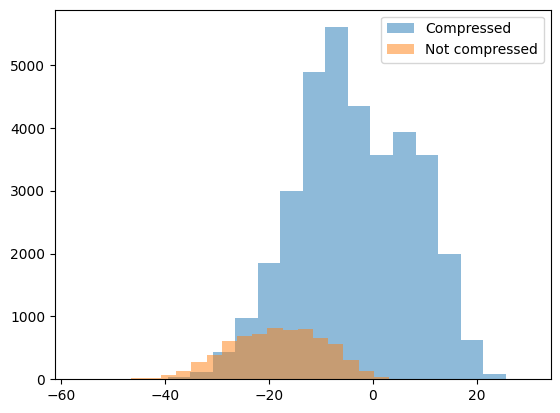

In [5]:
# Let's just plot the distribution of the scores divided by compressed or not compressed
compressed = results[results['compressed'] == True]
not_compressed = results[results['compressed'] == False]
plt.hist(compressed['logits'], bins=20, alpha=0.5, label='Compressed')
plt.hist(not_compressed['logits'], bins=20, alpha=0.5, label='Not compressed')
plt.legend(loc='upper right')

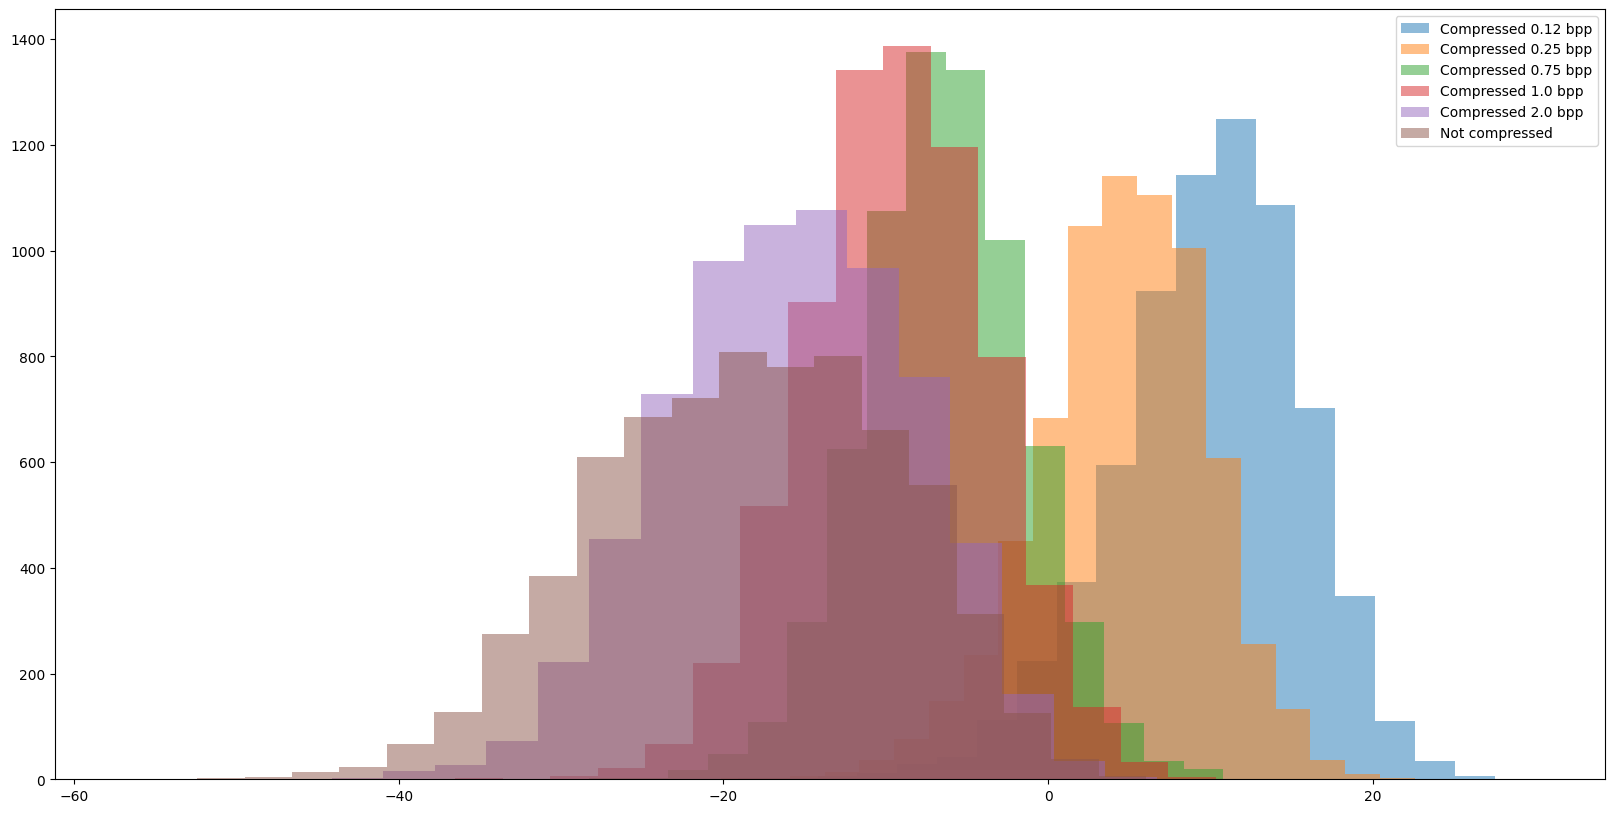

In [8]:
# Let's just plot the distribution of the scores divided by compressed or not compressed
compressed = results[results['compressed'] == True]
not_compressed = results[results['compressed'] == False]
plt.figure(figsize=(20, 10))
for target_bpp in compressed['target_bpp'].unique():
    plt.hist(compressed[compressed['target_bpp'] == target_bpp]['logits'], bins=20, alpha=0.5, label=f'Compressed {target_bpp} bpp')
plt.hist(not_compressed['logits'], bins=20, alpha=0.5, label='Not compressed')
plt.legend(loc='upper right')

## Let's divide by dataset

Text(0.5, 1.0, 'COCO scores')

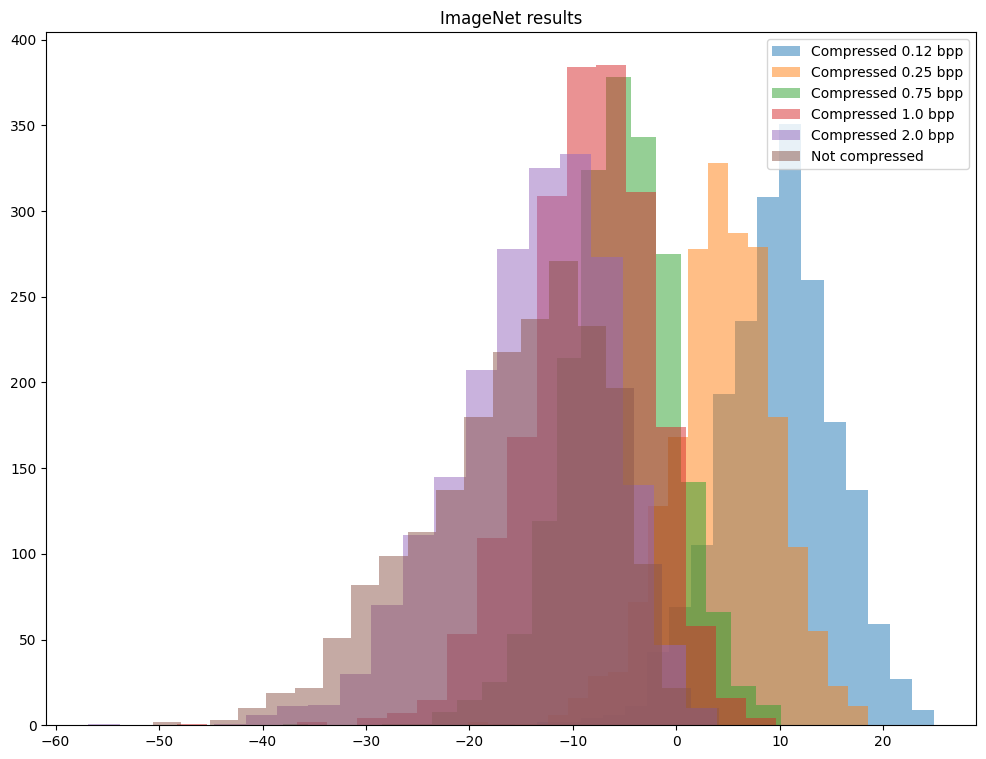

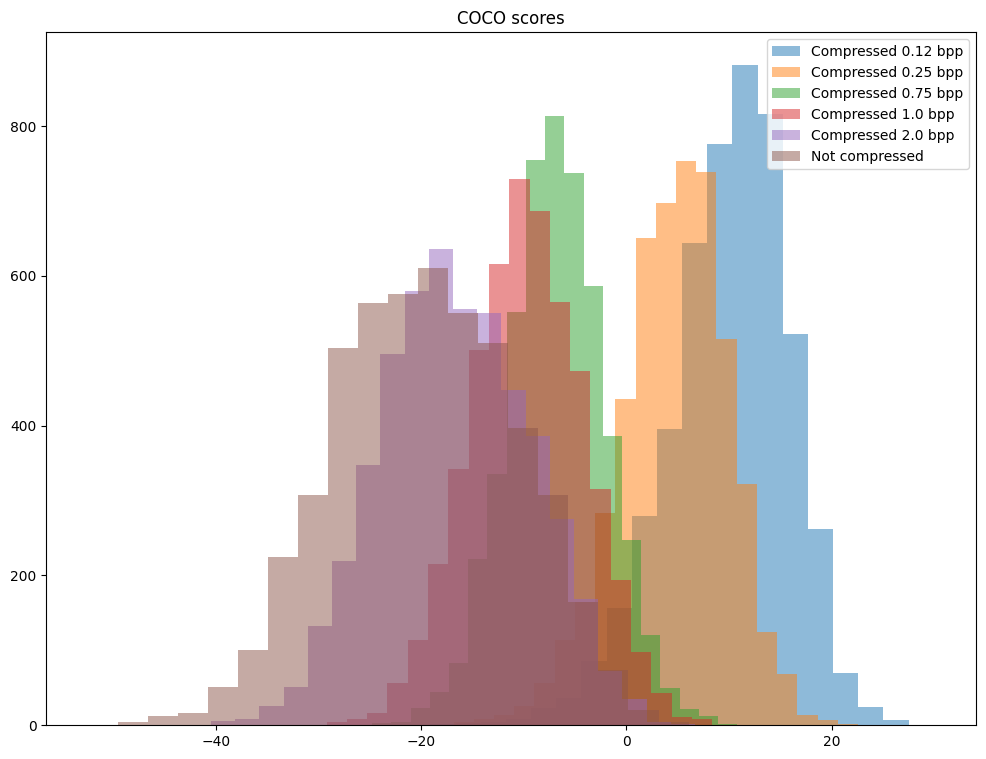

In [12]:
# --- Imagenet results
results_imagenet = results[results['dataset'] == 'imagenet']
compressed = results_imagenet[results_imagenet['compressed'] == True]
not_compressed = results_imagenet[results_imagenet['compressed'] == False]
plt.figure(figsize=(12, 9))
for target_bpp in compressed['target_bpp'].unique():
    plt.hist(compressed[compressed['target_bpp'] == target_bpp]['logits'], bins=20, alpha=0.5, label=f'Compressed {target_bpp} bpp')
plt.hist(not_compressed['logits'], bins=20, alpha=0.5, label='Not compressed')
plt.legend(loc='upper right')
plt.title('ImageNet results')

# --- COCO results
results_imagenet = results[results['dataset'] == 'coco']
compressed = results_imagenet[results_imagenet['compressed'] == True]
not_compressed = results_imagenet[results_imagenet['compressed'] == False]
plt.figure(figsize=(12, 9))
for target_bpp in compressed['target_bpp'].unique():
    plt.hist(compressed[compressed['target_bpp'] == target_bpp]['logits'], bins=20, alpha=0.5, label=f'Compressed {target_bpp} bpp')
plt.hist(not_compressed['logits'], bins=20, alpha=0.5, label='Not compressed')
plt.legend(loc='upper right')
plt.title('COCO scores')

## Let's compute some ROC curves

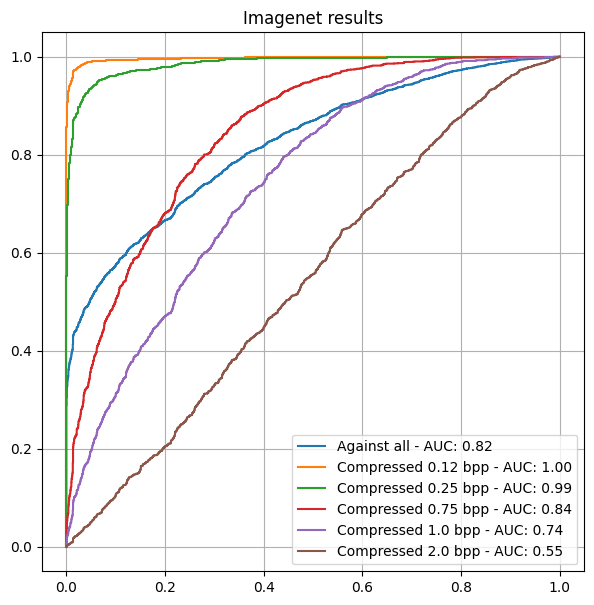

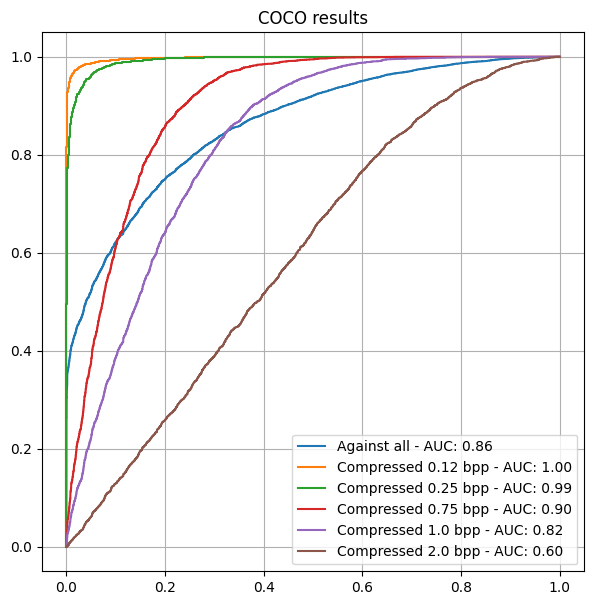

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
# --- Imagenet results
results_dataset = results[results['dataset'] == 'imagenet']
compressed = results_dataset[results_dataset['compressed'] == True]
not_compressed = results_dataset[results_dataset['compressed'] == False]
fpr, tpr, _ = roc_curve(results_dataset['compressed'], results_dataset['logits'])
# Compute area under the curve
roc_auc = roc_auc_score(results_dataset['compressed'], results_dataset['logits'])
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='Against all - AUC: %.2f' % roc_auc)
for target_bpp in compressed['target_bpp'].unique():
    dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
    fpr, tpr, _ = roc_curve(dataset['compressed'], dataset['logits'])
    # Compute area under the curve
    roc_auc = roc_auc_score(dataset['compressed'], dataset['logits'])
    plt.plot(fpr, tpr, label=f'Compressed {target_bpp} bpp - AUC: %.2f' % roc_auc)
plt.legend(loc='lower right')
plt.title('Imagenet results')
plt.grid()
plt.show()

# --- COCO results
results_dataset = results[results['dataset'] == 'coco']
compressed = results_dataset[results_dataset['compressed'] == True]
not_compressed = results_dataset[results_dataset['compressed'] == False]
fpr, tpr, _ = roc_curve(results_dataset['compressed'], results_dataset['logits'])
# Compute area under the curve
roc_auc = roc_auc_score(results_dataset['compressed'], results_dataset['logits'])
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label='Against all - AUC: %.2f' % roc_auc)
for target_bpp in compressed['target_bpp'].unique():
    dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
    fpr, tpr, _ = roc_curve(dataset['compressed'], dataset['logits'])
    # Compute area under the curve
    roc_auc = roc_auc_score(dataset['compressed'], dataset['logits'])
    plt.plot(fpr, tpr, label=f'Compressed {target_bpp} bpp - AUC: %.2f' % roc_auc)
plt.legend(loc='lower right')
plt.title('COCO results')
plt.grid()
plt.show()

## Let's compute the balanced accuracy at 0.5 threshold

In [19]:
from sklearn.metrics import balanced_accuracy_score
# --- Imagenet results
results_dataset = results[results['dataset'] == 'imagenet']
compressed = results_dataset[results_dataset['compressed'] == True]
not_compressed = results_dataset[results_dataset['compressed'] == False]
balanced_accuracy = balanced_accuracy_score(results_dataset['compressed'], results_dataset['logits'] > 0)
print(f'Balanced accuracy against all: {balanced_accuracy}')
for target_bpp in compressed['target_bpp'].unique():
    dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
    balanced_accuracy = balanced_accuracy_score(dataset['compressed'], dataset['logits'] > 0)
    print(f'Balanced accuracy compressed {target_bpp} bpp: {balanced_accuracy}')

# --- COCO results
results_dataset = results[results['dataset'] == 'coco']
compressed = results_dataset[results_dataset['compressed'] == True]
not_compressed = results_dataset[results_dataset['compressed'] == False]
balanced_accuracy = balanced_accuracy_score(results_dataset['compressed'], results_dataset['logits'] > 0)
print(f'Balanced accuracy against all: {balanced_accuracy}')
for target_bpp in compressed['target_bpp'].unique():
    dataset = pd.concat([compressed[compressed['target_bpp'] == target_bpp], not_compressed])
    balanced_accuracy = balanced_accuracy_score(dataset['compressed'], dataset['logits'] > 0)
    print(f'Balanced accuracy compressed {target_bpp} bpp: {balanced_accuracy}')

Balanced accuracy against all: 0.6933
Balanced accuracy compressed 0.12 bpp: 0.971
Balanced accuracy compressed 0.25 bpp: 0.90725
Balanced accuracy compressed 0.75 bpp: 0.56525
Balanced accuracy compressed 1.0 bpp: 0.524
Balanced accuracy compressed 2.0 bpp: 0.499
Balanced accuracy against all: 0.68568
Balanced accuracy compressed 0.12 bpp: 0.9686999999999999
Balanced accuracy compressed 0.25 bpp: 0.907
Balanced accuracy compressed 0.75 bpp: 0.5355
Balanced accuracy compressed 1.0 bpp: 0.5169
Balanced accuracy compressed 2.0 bpp: 0.5003
